In [24]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set_style('darkgrid')

%matplotlib widget

In [27]:

class SineWave:
    
    def __init__(self, train_size=10, valid_size=5, synth_size=5):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.resample(train_size, valid_size, synth_size)
       
       
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def sample(self, size=10):
        x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return dict(x=torch.Tensor(x), y=torch.Tensor(y))
    
    def resample(self, train_size=None, valid_size=None, synth_size=None):
        if train_size is not None:
            self.train_set = self.sample(train_size)
        if valid_size is not None:
            self.valid_set = self.sample(valid_size)
        if synth_size is not None:
            self.synth_set = self.sample(synth_size)
            self.synth_set['y'] = self.a * (2*torch.rand(self.synth_set['y'].shape)-1)
            
            
    
    def test_set(self):
        x = np.linspace(-5, 5, 100)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
        
    def plot(self, *args, **kwargs):
        plots = []
        legends = []
       
        train, = plt.plot(self.train_set['x'].numpy(), self.train_set['y'].numpy(), '^')
        plots.append(train)
        legends.append('Training Points')
   
        synth, = plt.plot(self.synth_set['x'], self.synth_set['y'], 'x')
        plots.append(synth)
        legends.append('Synthetic Points')
        x, y = self.test_set()
        test, = plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
        plots.append(test)
        legends.append("True Function")
        plt.legend(plots, legends)



In [28]:
class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 40)
        self.hidden2 = nn.Linear(40, 40)
        self.out = nn.Linear(40, 1)
        
    def forward(self, x, lr=None, gradients=None):
        if gradients is not None:
            layer1_weight = self.hidden1.weight - lr * gradients[0]
            layer1_bias = self.hidden1.bias.data - lr * gradients[1]
            layer2_weight = self.hidden2.weight.data - lr * gradients[2]
            layer2_bias = self.hidden2.bias.data - lr * gradients[3]
            out_weight = self.out.weight.data - lr * gradients[4]
            out_bias = self.out.bias.data - lr * gradients[5]
            x = F.relu(F.linear(x, layer1_weight, layer1_bias))
            x = F.relu(F.linear(x, layer2_weight, layer2_bias))
            x = F.linear(x, out_weight, out_bias)
            return x
            
        else:
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.out(x)
    
    def gradient_step_(self, lr, gradients):
        self.hidden1.weight.data = self.hidden1.weight.data - lr * gradients[0]
        self.hidden1.bias.data = self.hidden1.bias.data - lr * gradients[1]
        self.hidden2.weight.data = self.hidden2.weight.data - lr * gradients[2]
        self.hidden2.bias.data = self.hidden2.bias.data - lr * gradients[3]
        self.out.weight.data = self.out.weight.data - lr * gradients[4]
        self.out.bias.data = self.out.bias.data - lr * gradients[5]
        
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

In [41]:
from IPython import display

def fit(wave, net, epochs=10):
    x_train, y_train = wave.train_set.values()
    x_valid, y_valid = wave.valid_set.values()
    x = torch.cat([x_train, x_valid])
    y = torch.cat([y_train, y_valid])
    optim = torch.optim.Adam(net.parameters(), lr=0.01)
    fig, ax = plt.subplots()
    for epoch in range(1, epochs+1):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.1)
        optim.zero_grad()
        loss = F.mse_loss(net(x[:, None]), y.unsqueeze(1))
        print(f"Loss at epoch #{epoch}: {loss.data}")
        loss.backward()
        optim.step()
        ax.cla()
        plot_sine_test(ax, wave, net, show_synth=False)

def fit_meta(wave, net, lr_meta=1e-2, lr_z=5, epochs=10):
    x_train, y_train = wave.train_set.values()
    x_valid, y_valid = wave.valid_set.values()
    x_synth, y_synth = wave.synth_set.values()
    z = x_synth.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([z], lr=lr_z, momentum=0)
    fig, ax = plt.subplots()
    for epoch in range(1, epochs+1):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.1)
        optimizer.zero_grad()
        y_hat = net(x_train[:, None])
        loss_real = F.mse_loss(y_hat, y_train.reshape_as(y_hat))
        grad_real = grad(loss_real, net.parameters())
        print(f"Loss Epoch:#{epoch} on training {loss_real:.3}", end=", ")
        
        y_z = net(z[:, None])
        loss_z = F.mse_loss(y_z, y_synth.reshape_as(y_z))
        grad_synth = grad(loss_z, net.parameters(), create_graph=True)
        
        gradients = tuple(grad_real[i] + grad_synth[i] for i in range(len(grad_synth)))
        logits = net(x_valid[:, None], lr=lr_meta, gradients=gradients)
        loss_valid = F.mse_loss(logits, y_valid.reshape_as(logits))
        loss_valid.backward()
        print(f"Loss on validation {loss_valid:.3}")
        optimizer.step()
        net.gradient_step_(lr=lr_meta, gradients=gradients)
        ax.cla()
        wave.synth_set['x'] = z.clone().detach()
        plot_sine_test(ax, wave, net)

 
#     return fig, ax
    
    
        
@torch.no_grad()
def eval_net(wave, net):
    x, _ = wave.test_set()
    y = net(x[:, None])
    return x.squeeze().numpy(), y.squeeze().numpy()

def plot_sine_test(ax, wave, net, show_synth=True):
    
    xtest, ytest = wave.test_set()
    xtrain, ytrain = wave.train_set.values()
    xvalid, yvalid = wave.valid_set.values()
    xsynth, ysynth = wave.synth_set.values()
    _, res = eval_net(wave, net)
    
    ax.plot(xtrain.numpy(), ytrain.numpy(), '^', label='Training Points')
    ax.plot(xtest.numpy(), ytest.numpy(), label='True Function')
    ax.plot(xvalid.numpy(), yvalid.numpy(), '^', label='Validation Points')
    if show_synth:
        ax.plot(xsynth.numpy(), ysynth.numpy(), 'x', label='Synthetic Points')
    ax.plot(xtest.numpy(), res, '--', label="Model")    
    ax.legend()


In [37]:
wave = SineWave(train_size=5, valid_size=2, synth_size=5)
wave.plot()
plt.show()

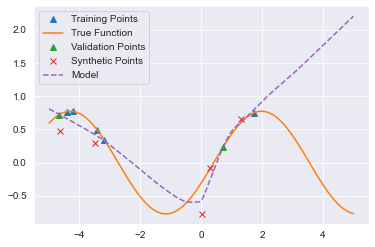

Loss Epoch:#1000 on training 0.00973, Loss on validation 2.65e-06


In [42]:
net = SineModel()
fit_meta(wave, net, epochs=1000)

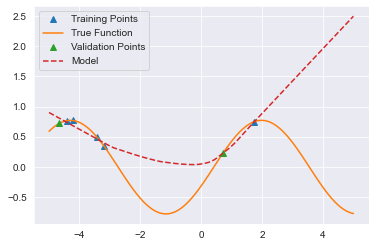

Loss at epoch #1000: 0.002775277476757765


In [39]:
net = SineModel()
fit(wave, net, epochs=1000)

In [172]:
fig, ax = plt.subplots()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …